In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from os import listdir

Mounted at /content/drive


#Base de datos:

Elements contained in the filenames:

1.Patient number (101,102,...,226)

2.Recording index

3.Chest location (Trachea (Tc), {Anterior (A), Posterior (P),,Lateral (L)}{left (l), right (r)})

4.Acquisition mode (sequential/single channel (sc),simultaneous/multichannel (mc))

5.Recording equipment (AKG C417L Microphone, 3M Littmann Classic II SE Stethoscope, 3M Litmmann 3200 Electronic Stethoscope, WelchAllyn Meditron Master Elite Electronic Stethoscope)

The abbreviations used in the diagnosis file are:
- COPD: Chronic Obstructive Pulmonary Disease
- LRTI: Lower Respiratory Tract Infection
- URTI: Upper Respiratory Tract Infection

In [ ]:
directory= "/content/drive/My Drive/Respiratory_Sound_Database/audio_and_txt_files/"#depende de cada drive
def ls(ruta = '.'):
    return listdir(ruta)
archivos=ls(directory)#lista de todos los archivos en la carpeta
archivos=[archivos[i][0:-4] for i in range(len(archivos)) if '.txt' in archivos[i]] #solo los nombres

litt=0
litt2=0
akg=0
Welch=0
for i in archivos:
  if 'AKGC417L' in i:
    akg+=1
  if 'LittC2SE' in i:
    litt+=1
  if 'Litt3200' in i:
    litt2+=1
  if 'Meditron' in i:
    Welch+=1

print('Grabaciones con AKG C417L: ', akg,'\nGrabaciones con LittC2SE: ',litt,
      '\nGrabaciones con Litt3200: ',litt2,'\nGrabaciones con WelchAllyn:', Welch,
      '\nGrabaciones totales: ',akg+litt+litt2+Welch)

Grabaciones con AKG C417L:  646 
Grabaciones con LittC2SE:  87 
Grabaciones con Litt3200:  60 
Grabaciones con WelchAllyn: 127 
Grabaciones totales:  920


In [ ]:
# En el archivo patient_diagnosis.csv se tiene el diagnostico de cada paciente
# Se pasa cada diagnostico a forma binaria 
diagnosis=pd.read_csv("/content/drive/My Drive/Respiratory_Sound_Database/patient_diagnosis.csv",header=None,names=['paciente','diagnostico'])
d=pd.get_dummies(diagnosis, columns = ['diagnostico'],sparse=False)
d

,paciente,diagnostico_Asthma,diagnostico_Bronchiectasis,diagnostico_Bronchiolitis,diagnostico_COPD,diagnostico_Healthy,diagnostico_LRTI,diagnostico_Pneumonia,diagnostico_URTI
0,101,0,0,0,0,0,0,0,1
1,102,0,0,0,0,1,0,0,0
2,103,1,0,0,0,0,0,0,0
3,104,0,0,0,1,0,0,0,0
4,105,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
121,222,0,0,0,1,0,0,0,0
122,223,0,0,0,1,0,0,0,0
123,224,0,0,0,0,1,0,0,0
124,225,0,0,0,0,1,0,0,0


In [ ]:
#Caracterizacion base de datos:
columnas=d.keys()[1:]
for k in columnas:
  print('Pacientes con ', k,':',sum(d[k].values))
print('Total de pacientes: ', len(d['paciente'].values))

Pacientes con  diagnostico_Asthma : 1
Pacientes con  diagnostico_Bronchiectasis : 7
Pacientes con  diagnostico_Bronchiolitis : 6
Pacientes con  diagnostico_COPD : 64
Pacientes con  diagnostico_Healthy : 26
Pacientes con  diagnostico_LRTI : 2
Pacientes con  diagnostico_Pneumonia : 6
Pacientes con  diagnostico_URTI : 14
Total de pacientes:  126


In [ ]:
#Para el caso de EPOC (COPD) se nesecita saber las fuentes de adquisicion
c1=c2=c3=c4=0
a=d[d['diagnostico_COPD']==1]['paciente'].values
for i in archivos:
  num_paciente=int(i[:3])
  for z in a:
    if num_paciente==z and ('AKGC417L' in i):
      c1+=1
      a=a[a!=num_paciente]
      break
    if num_paciente==z and ('LittC2SE' in i):
      c2+=1
      a=a[a!=num_paciente]
      break
    if num_paciente==z and ('Litt3200' in i):
      c3+=1
      a=a[a!=num_paciente]
      break
    if num_paciente==z and ('Meditron' in i):
      c4+=1
      a=a[a!=num_paciente]
      break
c1,c2,c3,c4

(32, 15, 9, 8)

# Extracción de Características

Luego de hacer una exploracon inicial y entrenando varios modelos se opto por solo usar características basadas en las MFCC.

Cada archivo de audio viene acopañado de anotaciones de inicio, fin de ciclo y presencia de crujidos y silibancias con el mismo nombre en fotmato .txt. 

$
 \begin{pmatrix}
  ti & tf &  & c & w\\
  1 & 2 &  & 0 & 1\\ 
  2.2 & 3 &  & 1 & 0\\
  3.5 & 4 &  & 1 & 1\\
  4.1 & 5 &  & 0 & 0\\
 \end{pmatrix}$

In [ ]:
from scipy.signal import resample
import librosa as lb
!pip install python_speech_features
from python_speech_features.base import mfcc

In [ ]:
def respiratory_cycle(s,resampl=0):
  '''
  Esta función extrae los ciclos respiratorios.
  Parametros
    s: nombre del archivo a leer (sin .wav)
    resampl: frecuencia a la que se quiere convertir
  Devuelve 
    data: conjunto de datos con los ciclos
    rate: frecuencia de muestreo de salida
    df_annot: conjunto de anotaciones
  '''
  path=directory + s +'.wav'
  x, rate = lb.load(path)

  path=directory + s +'.txt'
  df_annot = pd.read_csv(path,sep="\t")
  df_annot=df_annot.values

  if resampl!=0:
    x=resample(x,int(len(x)*(resampl/rate)),axis=0)
    rate=resampl

  data=[]

  #separar los ciclos
  for i in range(np.shape(df_annot)[0]):
    y=x[int(df_annot[i,0]*rate):int(df_annot[i,1]*rate)]
    y=y/np.max(np.abs(y))#normaliza

    data.append(y)
  return data,rate,df_annot

Archivo:  200_2p4_Pr_mc_AKGC417L
[[ 3.297  7.805  0.     0.   ]
 [ 7.805 11.594  0.     0.   ]
 [11.594 15.902  0.     0.   ]
 [15.902 17.387  0.     0.   ]] fs salida:  4000


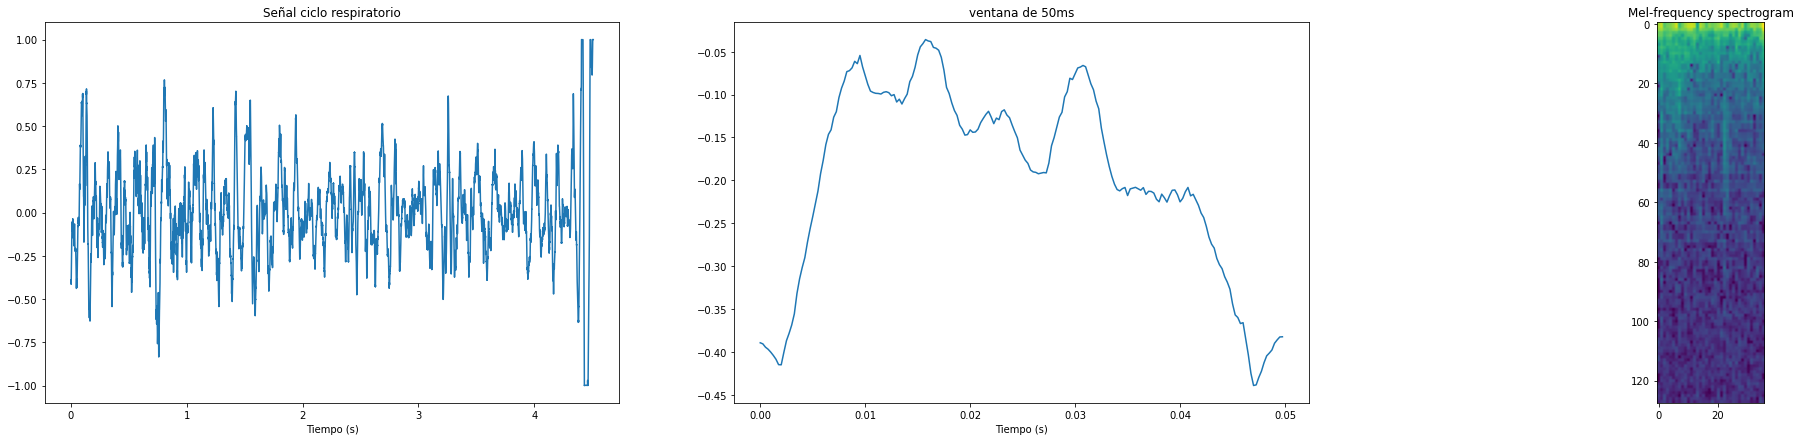

In [ ]:
f=archivos[33]
data,rate,df_annot=respiratory_cycle(f,resampl=4000)

print('Archivo: ',f)
print(df_annot,'fs salida: ',rate)

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(35,7))
s=data[0]
t=np.linspace(0,np.shape(s)[0]/rate,np.shape(s)[0])
ax[0].plot(t,s)
ax[0].set_title('Señal ciclo respiratorio')
ax[0].set_xlabel('Tiempo (s)')

t=np.linspace(0,np.shape(s)[0]/rate,np.shape(s)[0])
ax[1].plot(t[0:int(rate*0.05)],s[0:int(rate*0.05)])
ax[1].set_title('ventana de 50ms')
ax[1].set_xlabel('Tiempo (s)')

S=lb.feature.melspectrogram(y=s, sr=4000,n_fft=int(4000*0.05))
S_dB = lb.power_to_db(S, ref=np.max)
# img = lb.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=4000,
#                          fmax=8000, ax=ax[2])
# fig.colorbar(img, ax=ax[2], format='%+2.0f dB')

ax[2].set(title='Mel-frequency spectrogram')
ax[2].imshow(S_dB)

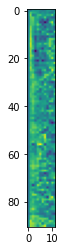

In [ ]:
m=mfcc(s, samplerate=4000, winlen=0.05, winstep=0.05, numcep=12, nfft=int(4000*0.05))
plt.imshow(m)

In [ ]:
def cycle_characteristics(s,rate,window):
  m=mfcc(s, samplerate=rate, winlen=window, winstep=window, numcep=12, nfft=int(rate*window))
  m=np.concatenate((np.mean(m,axis=0),np.std(m,axis=0)))
  return [m]

In [ ]:
m=mfcc(s, samplerate=4000, winlen=0.05, winstep=0.05, numcep=12, nfft=int(4000*0.05))
m.shape

(91, 12)

In [ ]:
cycle_characteristics(s,4000,0.05)

[array([-4.13577743, 10.00432957,  9.09846304,  4.14747002,  5.41550417,
         3.22183514,  2.737689  ,  3.94930891,  2.21895203,  3.17607887,
         3.40799526,  2.1421276 ,  0.70930811,  4.29925117,  4.95057235,
         6.03305831,  5.62352456,  6.41274569,  6.13705098,  7.36207981,
         6.01729058,  6.44801274,  7.04573671,  6.12946745])]

In [ ]:
len(archivos)

920

In [ ]:
w=0.05#ventana en segundos

c = []
cont=0
targets = []
for archivo in archivos:#recorrer la lista de archivos
  
  data,rate,df_annot=respiratory_cycle(archivo,resampl=4000)
  label2=d.loc[d['paciente']==int(archivo[:3])].values[0,4]

  for k in range(np.shape(df_annot)[0]):
    if (df_annot[k,1] - df_annot[k,0]) > 0.2 :
      c.append(cycle_characteristics(data[k],rate,w))
      targets.append([df_annot[k,2],df_annot[k,3],label2])
  cont+=1
  print(cont)

In [ ]:
carac=np.array(c,dtype=np.float64)
targets=np.array(targets,dtype=np.float64)

In [ ]:
texto='''mfcc1 m, mfcc2 m, mfcc3 m, mfcc4 m, mfcc5 m, mfcc6 m, mfcc7 m, mfcc8 m, mfcc9 m, mfcc10 m, mfcc11 m, mfcc12 m,mfcc1 s, mfcc2 s, mfcc3 s, mfcc4 s, mfcc5 s, mfcc6 s, mfcc7 s, mfcc8 s, mfcc9 s, mfcc10 s, mfcc11 s, mfcc12 s,crackles,wheezes,diagnostic'''
datos=pd.DataFrame(np.concatenate((carac[:,0,:],targets),axis=1),columns=texto.split(','))
datos.to_csv('/content/drive/MyDrive/Proyecto DBIO/Caracteristicas/Caracteristicas_MFCC_50ms.csv')

#Exploracion de las características

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as kr
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sys

In [ ]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['binary_accuracy'])+1),model_details.history['binary_accuracy'])
    axs[0].plot(range(1,len(model_details.history['val_binary_accuracy'])+1),model_details.history['val_binary_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_details.history['binary_accuracy'])+1),len(model_details.history['binary_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

In [ ]:
path='/content/drive/MyDrive/Proyecto DBIO/Caracteristicas'
f=pd.read_csv(path+'/Caracteristicas_MFCC_50ms.csv',index_col=0)
f

,mfcc1 m,mfcc2 m,mfcc3 m,mfcc4 m,mfcc5 m,mfcc6 m,mfcc7 m,mfcc8 m,mfcc9 m,mfcc10 m,mfcc11 m,mfcc12 m,mfcc1 s,mfcc2 s,mfcc3 s,mfcc4 s,mfcc5 s,mfcc6 s,mfcc7 s,mfcc8 s,mfcc9 s,mfcc10 s,mfcc11 s,mfcc12 s,crackles,wheezes,diagnostic
0,-4.325562,11.845219,14.293463,26.023607,2.239268,6.339317,3.472438,-7.622086,0.950418,-0.498311,-6.298896,0.768235,0.861545,4.612531,7.358380,6.997678,7.332259,5.717441,7.806895,6.973152,7.478287,7.595248,7.573812,5.952886,0.0,0.0,0.0
1,-4.572113,11.064278,14.450975,27.751237,3.209108,6.673259,2.838138,-6.945314,1.238973,-0.141324,-3.520401,0.978111,0.717466,3.238786,7.646404,5.726291,6.755161,5.312653,8.184996,6.267129,6.440546,7.044615,6.152739,6.623207,0.0,0.0,0.0
2,-4.769439,12.341134,15.792789,27.029552,3.405541,7.266328,2.587708,-8.054471,1.746058,-0.824808,-5.616485,1.003379,0.661841,3.798399,7.068331,6.824969,5.517278,5.741782,6.426936,5.544432,6.113375,6.101951,7.051808,5.687833,0.0,0.0,0.0
3,-3.406861,10.450745,14.576128,26.452817,2.506319,6.563818,3.296273,-8.352570,-0.673940,-1.661585,-5.259231,0.322623,0.593707,3.104011,6.060874,4.392143,4.963798,5.683131,5.872238,5.226772,5.075645,7.325476,6.992862,7.229533,0.0,0.0,0.0
4,-3.862665,11.746682,15.302933,26.163825,2.392035,6.036603,4.034139,-5.907636,-0.263498,-2.383164,-6.016081,-0.025184,0.574136,3.259521,6.163523,6.112891,5.190659,5.183080,7.023946,7.634712,7.619399,6.882325,7.573778,6.428819,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,-1.991363,-5.482871,2.849390,0.101879,0.700514,-6.050294,-1.755882,1.890543,-7.348998,-4.019094,-2.961909,0.598364,0.817318,5.635252,3.176017,3.579809,3.959030,6.587840,6.897109,8.200330,10.073446,7.720309,10.191933,9.407073,0.0,0.0,1.0
5974,-1.371821,-3.813627,2.028092,1.912772,-1.601282,-4.781792,-2.788988,-0.200601,-8.753257,-6.536735,-1.556089,-0.452823,0.315373,2.651307,3.288241,5.636955,4.650209,4.887438,6.092935,5.752665,7.373236,6.433431,7.040831,7.350555,0.0,0.0,1.0
5975,-2.724116,-1.892179,1.830296,-0.250166,-2.599367,-5.594400,-4.701707,-3.630819,-6.901352,-4.036807,-0.283455,-4.304826,0.309774,2.416371,3.439144,3.761115,5.567082,6.377176,5.973144,6.366639,6.950366,6.092132,6.004036,6.728183,0.0,0.0,1.0
5976,-2.103645,-1.235302,1.450567,-0.181664,-2.357806,-2.415833,-3.385951,-3.887069,-5.862250,-5.059459,-2.595032,-3.349506,0.224714,1.926317,2.763266,3.952098,3.867559,5.147122,6.242476,6.425690,6.546759,7.895408,7.038713,7.555032,0.0,0.0,1.0


In [ ]:
print('Número de muestras con crujidos: ',sum(f['crackles']),'\nNúmero de muestras con silibancias: ',sum(f['wheezes']),
      '\nNúmero de muestras totales: ',len(f))

Número de muestras con crujidos:  2078.0 
Número de muestras con silibancias:  1224.0 
Número de muestras totales:  5978


In [ ]:
np.random.seed(1)
data=f.values
X = data[:,:-3]
Y = data[:,-3:-1] #target para c y w
Y_copd= data[:,-1] #target para epoc
#scaler = StandardScaler()
scaler =MinMaxScaler((-1,1),True)#Nomaliza entre -1 y 1
X=scaler.fit_transform(X)

test_size= int(X.shape[0]*0.20) #20% para prueba
val_size = int(X.shape[0]*0.1) #10% para validacion

d = np.random.choice(np.arange(X.shape[0]) , size=X.shape[0], replace=False)
x_test = X[d[:test_size],:] 
x_val  = X[d[test_size:test_size+val_size],:]
x_train= X[d[test_size+val_size:],:] 

y_test = Y[d[:test_size]] 
y_val  = Y[d[test_size:test_size+val_size]]
y_train= Y[d[test_size+val_size:]] 

y_test_copd = Y_copd[d[:test_size]] 
y_val_copd  = Y_copd[d[test_size:test_size+val_size]]
y_train_copd= Y_copd[d[test_size+val_size:]] 

print('Dimensiones de prueba, validacion, entrenamiento: ',x_test.shape,x_val.shape,x_train.shape)

Dimensiones de prueba, validacion, entrenamiento:  (1195, 24) (597, 24) (4186, 24)


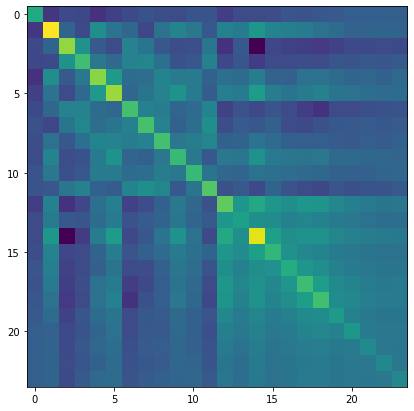

In [ ]:
plt.figure(figsize=(7,7))
df=pd.DataFrame(X)
plt.imshow(df.cov())

# Clasificación ANN

In [ ]:
global best_val_acc 
global best_val_loss 
global best_parameters
best_val_acc = 0
best_val_loss = sys.float_info.max 
best_parameters=['none' for i in range(5)]#guardare 5 paramtros
class MyCallback(kr.callbacks.Callback):
    def __init__(self,lr,tam_batch,neuronas,act,filename):
        self.lr=lr
        self.tam_batch=tam_batch
        self.neuronas=neuronas
        self.act=act
        self.filename=filename
    def on_epoch_end(self, epoch, logs=None):
        global best_val_acc 
        global best_val_loss
        global best_parameters
        val_acc = logs['val_binary_accuracy']
        val_loss = logs['val_loss']

        # if val_acc > best_val_acc:
        #     self.model.save(filename)
        #     print('lr: '+ str(self.lr),'batch: '+ str(self.tam_batch), 
        #           'num_neu: '+ str(self.neuronas),'activation: '+ str(self.act), 'epoch: '+ str(epoch))
        #     print('Improve from: % 2.5f to % 2.5f in acc' %(best_val_acc,val_acc))
        #     best_val_acc = val_acc 
        #     best_parameters=[str(self.neuronas),str(self.lr),str(self.act),str(self.tam_batch)]
        # elif val_acc == best_val_acc:
        if val_loss < best_val_loss:
            
            self.model.save(self.filename)
            print('lr: '+ str(self.lr),'batch: '+ str(self.tam_batch), 
                  'num_neu: '+ str(self.neuronas),'activation: '+ str(self.act), 'epoch: '+ str(epoch)) 
            print('Improve from: % 2.5f to % 2.5f in loss' %(best_val_loss,val_loss))  
            best_val_loss=val_loss 
            best_parameters=[str(self.neuronas),str(self.lr),str(self.act),str(self.tam_batch)]

In [ ]:
def model_g(numn=100,act='relu'):
  model = kr.Sequential()
    #capa 1
  model.add(kr.layers.Dense(numn, input_dim=24, activation=act))

  model.add(kr.layers.Dense(1, activation='sigmoid'))
  
  return model

In [ ]:
v_n=np.sort(np.array([np.random.randint(i,i+20) for i in range(40,200,20)]))#num neuronas
v_b=np.sort(np.array([np.random.randint(i,i+20) for i in range(20,140,20)]))#batch
v_l=[1.0e-3]#lr
v_a=['relu']#Activacion
auc=kr.metrics.AUC(name='AUC',multi_label=True)
v_n,v_b,v_l,v_a

(array([ 49,  64,  97, 117, 123, 144, 167, 183]),
 array([ 23,  59,  60,  86, 104, 123]),
 [0.001],
 ['relu'])

In [ ]:
resultados=[]
for neuronas in v_n:
  for lr in v_l:
    for activacion in v_a:
      for bache in v_b:     
          model=model_g(numn=int(neuronas),act=activacion)

          model.compile(loss="binary_crossentropy",
                        optimizer=kr.optimizers.Adam(lr=lr), 
                        metrics=['binary_accuracy',auc])

          details=model.fit(x_train, y_train_copd,
                    batch_size = int(bache),
                    epochs = 300,
                    validation_data=(x_val,y_val_copd),
                    callbacks=[MyCallback(lr=lr,tam_batch=bache,neuronas=neuronas,act=activacion,filename='Mejor_MFCC.h5')],
                    verbose=0)
          
          resultados.append([neuronas,lr,activacion,bache,min(details.history['val_loss'])])
          print('Fin de modelo: ',neuronas , lr , activacion, bache)
model=kr.models.load_model('Mejor_MFCC.h5')
model.save('/content/drive/MyDrive/Proyecto DBIO/Mejor_MFCC.h5')

lr: 0.001 batch: 23 num_neu: 49 activation: relu epoch: 0
Improve from:  179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00000 to  0.36465 in loss
lr: 0.001 batch: 23 num_neu: 49 activation: relu epoch: 1
Improve from:  0.36465 to  0.29258 in loss
lr: 0.001 batch: 23 num_neu: 49 activation: relu epoch: 2
Improve from:  0.29258 to  0.25568 in loss
lr: 0.001 batch: 23 num_neu: 49 activation: relu epoch: 3
Improve from:  0.25568 to  0.23711 in loss
lr: 0.001 batch: 23 num_neu: 49 activation: relu epoch: 4
Improve from:  0.23711 to  0.22506 in loss
lr: 0.001 batch: 23 num_neu: 49 activation: relu epoch: 5
Improve from:  0.22506 to  0.21589 in loss
lr: 0.001 batch: 23 num_neu: 49 activation: relu epoch: 6
Improve from:  0.21589 to  0

In [ ]:
resultados=np.array(resultados)
datos=pd.DataFrame(resultados,columns=['num_neuronas','lr','fun_activacion','tam_bache','mejor_perdida'])

In [ ]:
#queda guardado en la carpeta
datos.to_csv('/content/drive/MyDrive/Proyecto DBIO/busqueda_param_ruidos.csv')

Usar el archvo guardado

In [ ]:
f=pd.read_csv('/content/drive/MyDrive/Proyecto DBIO/busqueda_param_ruidos.csv',index_col=0)
resultados=f.values

In [ ]:
X_std = (resultados[:,4] - min(resultados[:,4])) / (max(resultados[:,4]) - min(resultados[:,4]))
resultados[:,4] = X_std  


Text(0.5, 1.0, 'Mapa de Calor\n act: relu   lr: 0.001')

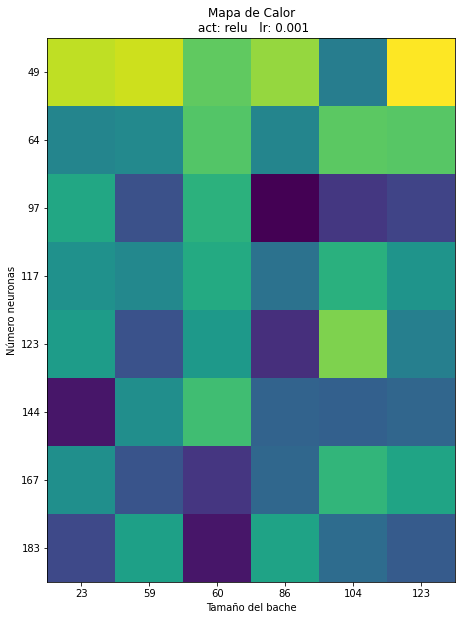

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=1,figsize=(10,10))
axs.imshow(np.reshape(np.array(resultados[:,4],dtype=np.float32),(len(v_n),len(v_b))))
axs.set_xticks(np.arange(len(v_b)))
axs.set_xticklabels(v_b)
axs.set_xlabel('Tamaño del bache')
axs.set_yticks(np.arange(len(v_n)))
axs.set_yticklabels(v_n)
axs.set_ylabel('Número neuronas')
axs.set_title('Mapa de Calor\n act: relu   lr: 0.001')

mas exploración

#Modelo Final

In [ ]:
model=kr.models.load_model('/content/drive/MyDrive/Proyecto DBIO/Mejor_MFCC.h5')
model.evaluate(x_train,y_train_copd)
model.evaluate(x_val,y_val_copd)
model.evaluate(x_test,y_test_copd)
model.summary()

38/38 [==============================] - 0s 2ms/step - loss: 0.0647 - binary_accuracy: 0.9766 - AUC: 0.9917
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 97)                2425      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 98        
Total params: 2,523
Trainable params: 2,523
Non-trainable params: 0
_________________________________________________________________


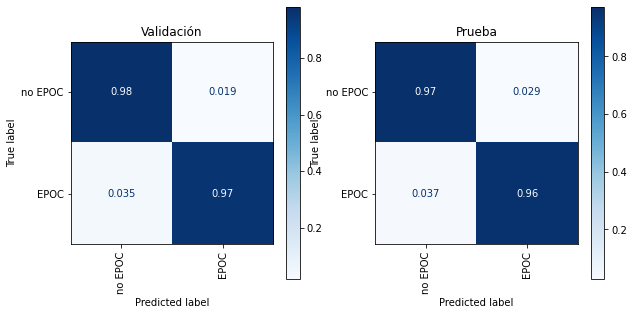

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#---------------------------------------------------------------conjunto validacion
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
y_pred_total=model.predict(x_val)
y_pred=y_pred_total[:,:]>0.8

cm = confusion_matrix(y_val_copd,y_pred,normalize='true')
cmp = ConfusionMatrixDisplay(cm, display_labels=('no EPOC','EPOC'))
ax[0].set_title('Validación')
cmp.plot(cmap='Blues',xticks_rotation='vertical',ax=ax[0])

y_pred_total=model.predict(x_test)
y_pred=y_pred_total[:,:]>0.8

cm = confusion_matrix(y_test_copd,y_pred,normalize='true')
cmp = ConfusionMatrixDisplay(cm, display_labels=('no EPOC','EPOC'))
ax[1].set_title('Prueba')
cmp.plot(cmap='Blues',xticks_rotation='vertical',ax=ax[1])



In [ ]:
def model_g(numn=100,act='relu'):
  model = kr.Sequential()
    #capa 1
  model.add(kr.layers.Dense(numn, input_dim=24, activation=act))

  model.add(kr.layers.Dense(1, activation='sigmoid'))
  
  return model

model=model_g(numn=97,act='relu')

model.compile(loss="binary_crossentropy",
              optimizer=kr.optimizers.Adam(lr=0.001), 
              metrics=['binary_accuracy',auc])

details=model.fit(x_train, y_train_copd,
          batch_size = 86,
          epochs = 300,
          validation_data=(x_val,y_val_copd),
          verbose=0)

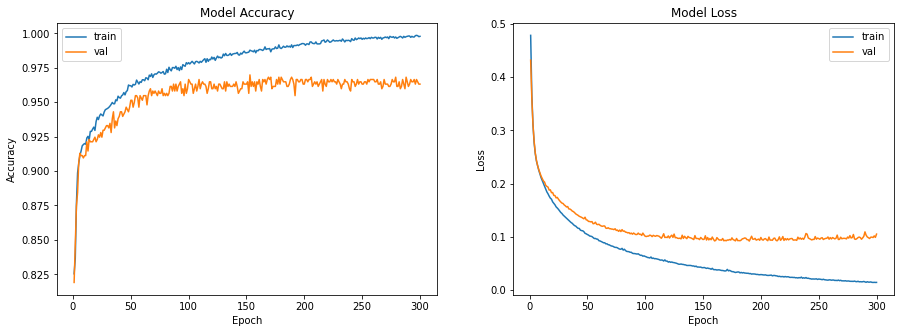

38/38 [==============================] - 0s 3ms/step - loss: 0.0544 - binary_accuracy: 0.9791 - AUC: 0.9970
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 97)                2425      
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 98        
Total params: 2,523
Trainable params: 2,523
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(details)
model.evaluate(x_train,y_train_copd)
model.evaluate(x_val,y_val_copd)
model.evaluate(x_test,y_test_copd)
model.summary()